In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.export import ExportArchive

2025-01-02 17:20:39.170863: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1735834838.485881    1333 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1735834838.517477    1333 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-02 17:20:38.784458: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
images_csv = pd.read_csv('emotions.csv')

In [3]:
images_csv.head()

,image_path,label
0,/home/adam/Bachelor/emotions/sad/image0029680.jpg,sad
1,/home/adam/Bachelor/emotions/sad/image0024066.jpg,sad
2,/home/adam/Bachelor/emotions/sad/image0009807.jpg,sad
3,/home/adam/Bachelor/emotions/sad/image0018272.jpg,sad
4,/home/adam/Bachelor/emotions/sad/image0026864.jpg,sad


In [4]:
images_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  25000 non-null  object
 1   label       25000 non-null  object
dtypes: object(2)
memory usage: 390.8+ KB


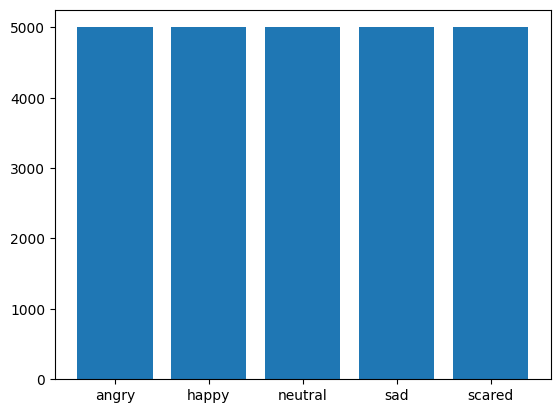

In [5]:
photos_by_emotions = images_csv.groupby('label').count()
plt.bar(photos_by_emotions.index, photos_by_emotions['image_path']);

In [9]:
emotions = images_csv['label'].unique()
emotions_dic = {}
for index, emotion in enumerate(emotions):
    emotions_dic[emotion] = index

print(emotions_dic)

{'sad': 0, 'scared': 1, 'neutral': 2, 'happy': 3, 'angry': 4}


In [10]:
e_images = images_csv.replace(emotions_dic)
e_images.head()

/tmp/ipykernel_1333/3825047754.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  e_images = images_csv.replace(emotions_dic)


,image_path,label
0,/home/adam/Bachelor/emotions/sad/image0029680.jpg,0
1,/home/adam/Bachelor/emotions/sad/image0024066.jpg,0
2,/home/adam/Bachelor/emotions/sad/image0009807.jpg,0
3,/home/adam/Bachelor/emotions/sad/image0018272.jpg,0
4,/home/adam/Bachelor/emotions/sad/image0026864.jpg,0


In [11]:
X = e_images['image_path']
y = e_images['label']

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.4, random_state=123, stratify=y)

In [14]:
len(X_train), len(X_test)

(15000, 10000)

In [10]:
dataset_train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
dataset_test = tf.data.Dataset.from_tensor_slices((X_test, y_test))

I0000 00:00:1735590794.334346    5016 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4701 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1060 with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 6.1


In [11]:
def load_image(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.rgb_to_grayscale(image)
    image = tf.image.resize(image, [100, 100])
    image = image / 255.0
    return image, label

In [12]:
dataset_train = dataset_train.map(load_image)
dataset_test = dataset_test.map(load_image)

In [13]:
dataset_train = dataset_train.batch(10).prefetch(tf.data.AUTOTUNE)
dataset_test = dataset_test.batch(10).prefetch(tf.data.AUTOTUNE)

In [14]:
for images, labels in dataset_train.take(2):
    print(f"Images shape: {images.shape}")
    print(f"Labels: {labels}")

Images shape: (10, 100, 100, 1)
Labels: [4 0 3 3 2 1 4 2 3 4]
Images shape: (10, 100, 100, 1)
Labels: [0 3 1 2 1 4 0 4 1 3]


2024-12-30 21:33:15.087060: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


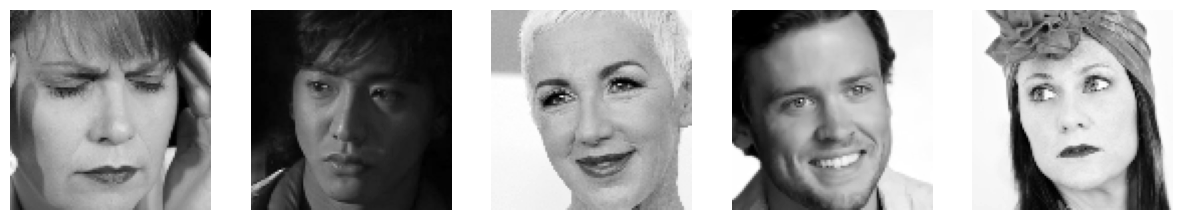

2024-12-30 21:33:16.008981: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [15]:
for images, _ in dataset_train.take(1):
    fig, axes = plt.subplots(1, 5, figsize=(15, 3))
    for i, ax in enumerate(axes):
        ax.imshow(images[i].numpy(), cmap='gray')
        ax.axis('off')
    plt.show()

In [16]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout

In [17]:
model = Sequential()
# warstwa konwulucyjna kernel = (3,3) wejście: 1 wyjście: 10 funckja aktywacji ReLU
model.add(Conv2D(10, (3, 3), activation = 'relu', input_shape=(100, 100, 1))) 
# Max pooling kernel = (2,2)
model.add(MaxPooling2D((2, 2))) 
# Droput z szansą 25%
model.add(Dropout(0.25)) 
# warstwa konwulucyjna kernel = (3,3) wejście: 10 wyjście: 30 funckja aktywacji ReLU
model.add(Conv2D(30, (3, 3), activation = 'relu'))  
# Max pooling kernel = (2,2)
model.add(MaxPooling2D((2, 2))) 
# Droput z szansą 25%
model.add(Dropout(0.25)) 
# Zamiana macierzy na wektor
model.add(Flatten()) 
# w pełni połączona sieć neuronowa wejście: 15870 wyjście: 500 funckja aktywacji ReLU
model.add(Dense(500, activation = 'relu')) 
# Droput z szansą 50%
model.add(Dropout(0.5)) 
# w pełni połączona sieć neuronowa wejście: 500 wyjście: 5 funckja aktywacji log_softmax
model.add(Dense(5, activation = 'log_softmax')) 

/home/adam/anaconda3/envs/tensorflow/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [18]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 98, 98, 10)     │           100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 49, 49, 10)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 49, 49, 10)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 47, 47, 30)     │         2,730 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 23, 23, 30)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 23, 23, 30)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 15870)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 500)            │     7,935,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         2,505 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,940,835 (30.29 MB)

 Trainable params: 7,940,835 (30.29 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer = optimizer, loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [20]:
history = model.fit(dataset_train, epochs=30)

Epoch 1/30


I0000 00:00:1735590802.051081    5065 service.cc:148] XLA service 0x7f509c00a820 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1735590802.051153    5065 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce GTX 1060 with Max-Q Design, Compute Capability 6.1
2024-12-30 21:33:22.161014: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1735590802.387676    5065 cuda_dnn.cc:529] Loaded cuDNN version 90300
2024-12-30 21:33:23.009700: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{} for conv (f32[10,30,47,47]{3,2,1,0}, u8[0]{0}) custom-call(f32[10,10,49,49]{3,2,1,0}, f32[30,10,3,3]{3,2,1,0}, f32[30]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_co

   9/1500 ━━━━━━━━━━━━━━━━━━━━ 29s 20ms/step - accuracy: 0.2929 - loss: 2.1038

I0000 00:00:1735590805.504652    5065 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 40s 23ms/step - accuracy: 0.2732 - loss: 1.5888
Epoch 2/30
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 56s 37ms/step - accuracy: 0.4307 - loss: 1.3626
Epoch 3/30
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 36s 24ms/step - accuracy: 0.4973 - loss: 1.2308
Epoch 4/30
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 35s 23ms/step - accuracy: 0.5433 - loss: 1.1211
Epoch 5/30
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 36s 24ms/step - accuracy: 0.5890 - loss: 1.0218
Epoch 6/30
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 36s 24ms/step - accuracy: 0.6289 - loss: 0.9399
Epoch 7/30
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 39s 26ms/step - accuracy: 0.6687 - loss: 0.8570
Epoch 8/30
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 40s 27ms/step - accuracy: 0.6997 - loss: 0.7788
Epoch 9/30
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 40s 27ms/step - accuracy: 0.7358 - loss: 0.6926
Epoch 10/30
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 40s 26ms/step - accuracy: 0.7664 - loss: 0.6275
Epoch 11/30
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 41s 27ms/step - accuracy: 0.7830 - loss: 0.5763
Epoch 12/30
1500/15

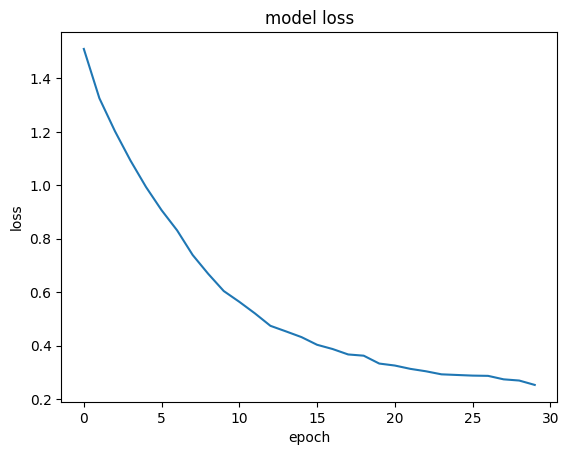

In [21]:
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [22]:
model.evaluate(dataset_test)

2024-12-30 21:53:33.751023: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{} for conv (f32[10,30,47,47]{3,2,1,0}, u8[0]{0}) custom-call(f32[10,10,49,49]{3,2,1,0}, f32[30,10,3,3]{3,2,1,0}, f32[30]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 24s 23ms/step - accuracy: 0.5112 - loss: 2.2115


[2.171710729598999, 0.5210999846458435]

In [23]:
model.evaluate(dataset_train)

1500/1500 ━━━━━━━━━━━━━━━━━━━━ 34s 23ms/step - accuracy: 0.9883 - loss: 0.0517


[0.05863402411341667, 0.9857333302497864]

In [26]:
@tf.function(input_signature=[tf.TensorSpec(shape=(None), dtype=tf.string)])
def pre_and_pro_process(images_bytes):
    def preprocess(image_bytes):
        len_img = tf.strings.length(image_bytes)
        image_raw = tf.strings.substr(image_bytes, pos=2, len=len_img - 3)
        image_raw = tf.io.decode_base64(image_raw)
        image = tf.image.decode_image(image_raw, channels=3, expand_animations = False)
        image = tf.image.rgb_to_grayscale(image)
        image = tf.image.resize(image, [100, 100])
        image = image / 255.0

        return image
        
    # preprocess
    images = tf.map_fn(preprocess, images_bytes, dtype=tf.float32)

    # predict
    predictions = tf.math.exp(model(images))

    # postprocess
    def map_to_dict(prediction):
        emotions = ['sad', 'scared', 'neutral', 'happy', 'angry']
        prediction_strings = tf.strings.as_string(prediction)
        pairs = tf.stack([emotions, prediction_strings], axis=1)

        def join_pair(pair):
            return tf.strings.join([pair[0], ": ", pair[1]])

        joined_pairs = tf.map_fn(join_pair, pairs, dtype=tf.string)

        result = tf.strings.join(["{",tf.strings.reduce_join(joined_pairs, separator=", "), "}"])
        return result
        
    formatted_predictions = tf.map_fn(map_to_dict, predictions, dtype=tf.string)
    
    return formatted_predictions      

In [27]:
export_archive = ExportArchive()
export_archive.track(model)
export_archive.add_endpoint(name="serve", fn=pre_and_pro_process)
export_archive.write_out("model_store_tf/1/")

INFO:tensorflow:Assets written to: model_store_tf/1/assets


INFO:tensorflow:Assets written to: model_store_tf/1/assets


Saved artifact at 'model_store_tf/1/'. The following endpoints are available:

* Endpoint 'serve'
  images_bytes (POSITIONAL_OR_KEYWORD): TensorSpec(shape=<unknown>, dtype=tf.string, name=None)
Output Type:
  TensorSpec(shape=(None,), dtype=tf.string, name=None)
Captures:
  139987273047504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139987265723152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139989964856432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139987270436288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139987272415744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139987272416976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139987272410112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139987272412224: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [6]:
import json
import base64

In [19]:
samples_links = {}
#images_csv
for i in emotions:
    samples_links[i] = images_csv[images_csv["label"] == i]["path"].sample(n=20, random_state=42).to_list()

In [33]:
requests = []
for key, values in samples_links.items():
    for link in values:
        with open(f"dataset/{link}", "rb") as image_file:
            r = str(base64.urlsafe_b64encode(image_file.read()))
            request = {"instances": [r]}
            requests.append(request)

with open("sample.json", "w") as outfile:
    json.dump(requests, outfile)